In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.init as init
import numpy as np
from opt_einsum import contract

class FCN3NetworkEnsembleLinear(nn.Module):
    def __init__(self, d, n1, n2, ens=1, weight_initialization_variance=(1.0, 1.0, 1.0)):
        super().__init__()
        self.arch = [d, n1, n2]
        self.d = d
        self.n1 = n1
        self.n2 = n2
        self.W0 = nn.Parameter(torch.normal(mean=0.0,
                                           std=torch.full((ens, n1, d), weight_initialization_variance[0]**0.5)).to(device),
                               requires_grad=True)
        self.W1 = nn.Parameter(torch.normal(mean=0.0,
                                           std=torch.full((ens, n2, n1), weight_initialization_variance[1]**0.5)).to(device),
                               requires_grad=True)
        self.A = nn.Parameter(torch.normal(mean=0.0,
                                          std=torch.full((ens, 1, n2), weight_initialization_variance[2]**0.5)).to(device),
                              requires_grad=True)

    def h1_activation(self, X):
        return contract(
            'ijk,ikl,unl->uij',
            self.W1, self.W0, X,
            backend='torch'
        )

    def h0_activation(self, X):
        return contract(
            'ikl,unl->uik',
            self.W0, X,
            backend='torch'
        )

    def forward(self, X):
        """
        Efficiently computes the outputs of a three layer network using opt_einsum
        f : P*d -> P*e*1
        C1_ui = W1_ijk*x_uk
        C2_uij = W2_ijk*C1_uik
        C3_ui = A_ij*C2_uij
        """
        A = self.A
        W1 = self.W1
        W0 = self.W0
        return contract(
            'eij,ejk,ekl,ul->uie',
            A, W1, W0, X,
            backend='torch'
        )


# 2. Generate Data
input_size = 20
hidden_size = 400
output_size = 1
num_samples = 20
epochs = 100_000_000 # You might increase this with a decaying LR

k = 1.0
t = 2 * k # Temperature for Langevin (currently unused in pure GD, but defined)

# --- Learning Rate Schedule Parameters ---
import math as mt
T = 800_000
lrA = 1e-8 / num_samples
lrB = (1.0 / 3) * lrA / num_samples 
beta =  mt.log(lrA / lrB) / T

print(lrA * mt.exp(-beta * 1000))

# ------------------------------------------
# Set the default dtype to float64
torch.set_default_dtype(torch.float64)

device = torch.device("cuda:1")
# Set seeds as constants
DATA_SEED = 613
MODEL_SEED = 26
LANGEVIN_SEED = 480

# Seed for data
torch.manual_seed(DATA_SEED)
X = torch.randn((num_samples, input_size), dtype=torch.float64).to(device)
Y = X[:,0].unsqueeze(-1).to(device)

# Seed for model
torch.manual_seed(MODEL_SEED)
ens = 100
model = FCN3NetworkEnsembleLinear(input_size, hidden_size, hidden_size,
                                 ens=ens,
                                 weight_initialization_variance=(1/input_size, 1.0/hidden_size, 1.0/(hidden_size**2))).to(device)
file = '/home/akiva/gpnettrain/P_20_D_20_N_400_epochs_2000000_lrA_5.00e-08_time_20250716_170626'

4.974475717953048e-10


In [7]:
import os

# Helper to strip "_orig_mod." prefix from state_dict keys if present
def strip_orig_mod_prefix(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("_orig_mod."):
            new_key = k[len("_orig_mod."):]
        else:
            new_key = k
        new_state_dict[new_key] = v
    return new_state_dict

load_model_filename2 = os.path.join(file, 'model.pth')
state_dict = torch.load(load_model_filename2, map_location=device)
# Fix keys if needed
if any(k.startswith("_orig_mod.") for k in state_dict.keys()):
    state_dict = strip_orig_mod_prefix(state_dict)
model.load_state_dict(state_dict)
print(f"Loaded model state_dict from {load_model_filename2}")
model = model.to(device)
model.eval() # Set model to evaluation mode
with torch.no_grad():
    predicted_Y = model(X).cpu().mean(axis=2).detach().numpy()
prediction = model(X).cpu().detach().mean(-1)

Loaded model state_dict from /home/akiva/gpnettrain/P_20_D_20_N_400_epochs_2000000_lrA_5.00e-08_time_20250716_170626/model.pth


In [9]:
losses = []
epoch_nums = []

with open(os.path.join(file, 'losses.txt'), "r") as f:
    for line in f:
        line = line.strip()
        if line:  # Ensure the line is not empty
            parts = line.split(',')
            if len(parts) == 2:
                try:
                    epoch = int(parts[0].strip())
                    loss = float(parts[1].strip())
                    epoch_nums.append(epoch)
                    losses.append(loss)
                except ValueError:
                    print(f"Skipping malformed line: {line}")
            else:
                print(f"Skipping line with incorrect format: {line}")

losses = np.array(losses)
epoch_nums = np.array(epoch_nums)

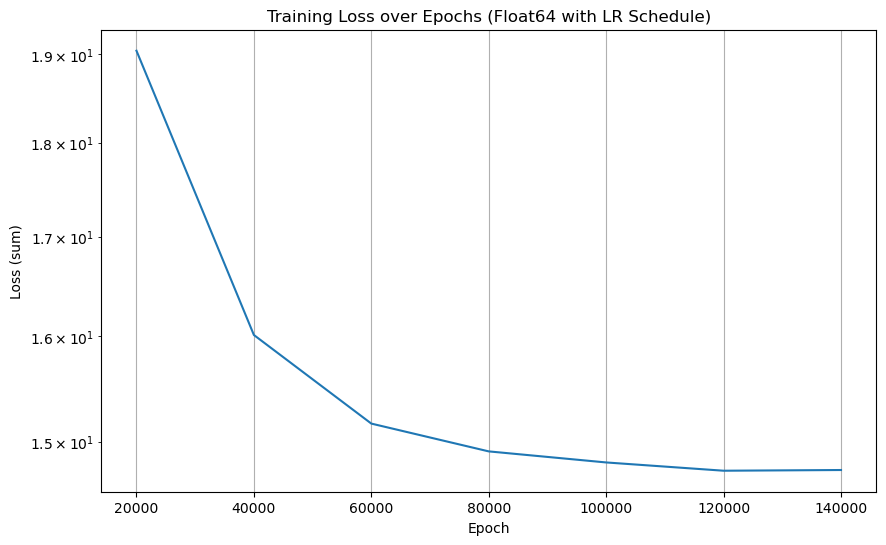

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(epoch_nums, losses / num_samples)
plt.xlabel('Epoch')
plt.ylabel('Loss (sum)')
plt.title('Training Loss over Epochs (Float64 with LR Schedule)')
plt.grid(True)
plt.yscale('log')
plt.show()

In [11]:
pred = model(X).cpu().detach()



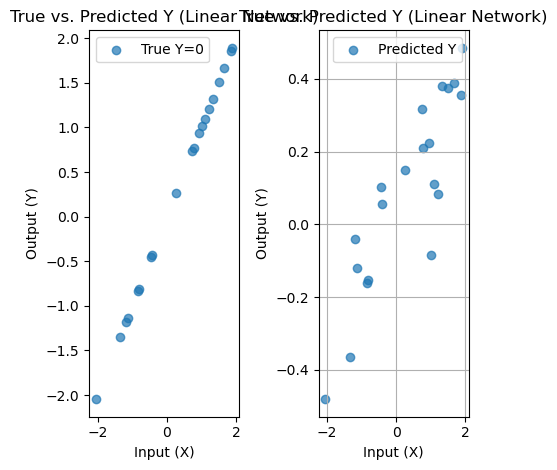

In [12]:
# 4. Visualize Results
model.eval() # Set model to evaluation mode
with torch.no_grad():
    predicted_Y = pred.mean(axis=2).numpy()

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 3, 1)
# plt.plot(losses)
# plt.title('Loss over Epochs (Linear Network)')
# plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')

plt.subplot(1, 3, 2)
plt.scatter(X[:,0].cpu().detach().numpy(), Y.cpu().detach().numpy(), label='True Y=0', alpha=0.7)
plt.title('True vs. Predicted Y (Linear Network)')
plt.xlabel('Input (X)')
plt.ylabel('Output (Y)')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(X[:,0].cpu().detach().numpy(), predicted_Y, label='Predicted Y', alpha=0.7)
plt.title('True vs. Predicted Y (Linear Network)')
plt.xlabel('Input (X)')
plt.ylabel('Output (Y)')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

# print("\nModel learned parameters (Linear Network with Langevin Dynamics):")
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(f"{name}: {param.data.numpy()}")

In [13]:
from opt_einsum import contract
W0 = model.W0.permute(*torch.arange(model.W0.dim() - 1, -1, -1))
W1 = model.W1.permute(*torch.arange(model.W1.dim() - 1, -1, -1))
covW0W1 = contract('kje,ije,nme,kme->in', W1,W0,W0,W1, backend='torch') / (hidden_size * ens)
y = covW0W1.diagonal().detach().cpu().numpy().tolist()


In [14]:
covW0W1 = contract('kje,ije,nme,kme->in', W1,W0,W0,W1, backend='torch') / (hidden_size * ens)
y = covW0W1.diagonal().detach().cpu().numpy().tolist()
y

[0.049600334245729155,
 0.049075492033348385,
 0.050228195519883584,
 0.05003114708541012,
 0.04993456443991596,
 0.04956660459005231,
 0.05021909677841484,
 0.05007998017545231,
 0.05015795930332889,
 0.05031187431569703,
 0.05073784882590361,
 0.05016088893907605,
 0.05012005223887899,
 0.05025598577819006,
 0.050373025078064716,
 0.05068167207058366,
 0.04937680094451682,
 0.049730766438481046,
 0.049713907741462796,
 0.04994460257101026]

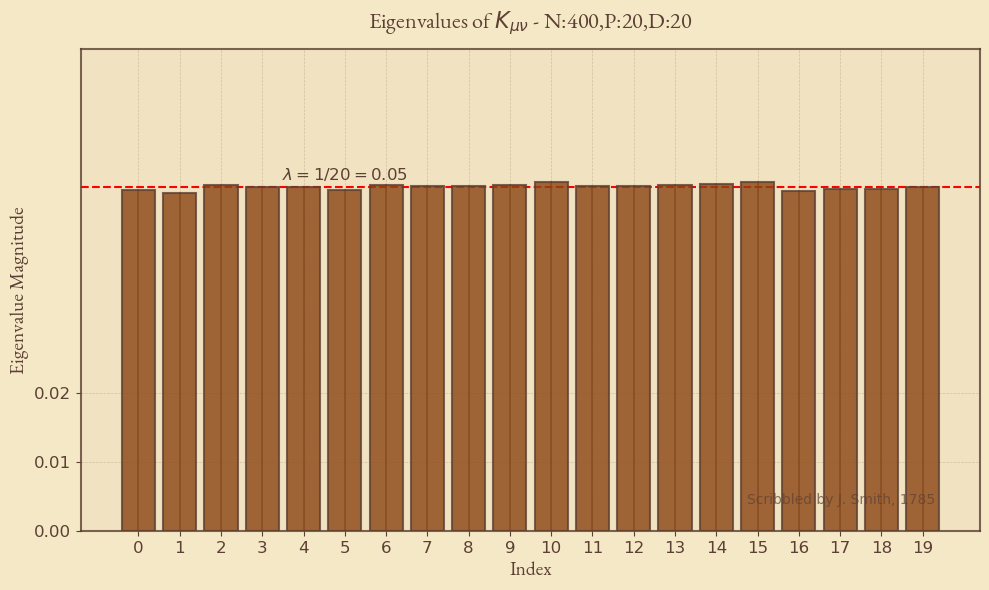

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.font_manager as fm

# Placeholder for covW0W1.diagonal() (replace with actual data)
x = range(len(y))  # Labels as range(len(y))

# Set a parchment-like background
fig = plt.figure(figsize=(10, 6), facecolor='#f5e8c7')  # Parchment beige
ax = fig.add_subplot(111, facecolor='#f5e8c7')
ax.set_facecolor('#f5e8c7')

# Add texture to simulate parchment imperfections
ax.add_patch(Rectangle((0, 0), 1, 1, transform=ax.transAxes, zorder=0, 
                       facecolor='#e8d9b9', alpha=0.3, linewidth=0))

# Plot data with a pencil-sketch style
bars = ax.bar(x, y, color='#8B4513', edgecolor='#5c4033', linewidth=1.5, 
              alpha=0.8, zorder=3)

# Add nib-pen effect to edges
for bar in bars:
    bar.set_linewidth(1.5)
    bar.set_edgecolor('#5c4033')
    height = bar.get_height()
    ax.plot([bar.get_x() + bar.get_width()/2, bar.get_x() + bar.get_width()/2], 
            [0, height], color='#5c4033', linestyle='-', linewidth=1.2, alpha=0.7)
    
# Customize axes and labels with a handwritten font
try:
    handwritten_font = fm.FontProperties(fname='/home/akiva/fonts/EBGaramond.ttf')  # Replace with a real path to a font like 'Great Vibes'
except:
    handwritten_font = None  # Fallback if font not found

if handwritten_font:
    plt.xlabel('Index', fontproperties=handwritten_font, color='#5c4033', fontsize=14)
    plt.ylabel('Eigenvalue Magnitude', fontproperties=handwritten_font, color='#5c4033', fontsize=14)
    plt.title('Eigenvalues of $K_{\\mu \\nu}$ - N:400,P:20,D:20', fontproperties=handwritten_font, color='#5c4033', fontsize=16, pad=15)
else:
    plt.xlabel('Index', fontstyle='italic', color='#5c4033', fontsize=14)
    plt.ylabel('Eigenvalue Magnitude', fontstyle='italic', color='#5c4033', fontsize=14)
    plt.title('Eigenvalues of $K_{\\mu \\nu}$', fontstyle='italic', color='#5c4033', fontsize=16, pad=15)
    
# Add grid with a faint, irregular pencil look
ax.grid(True, linestyle='--', linewidth=0.5, color='#a68a64', alpha=0.4, zorder=1)

# Set axis limits and ticks with an aged style
ax.set_ylim(0, max(y) * 1.1)  # Adjusted to 10% above max(y) for better fit
ax.set_xticks(x)
ax.set_yticks(np.arange(0, 0.03, step=0.01))  # Finer ticks, adjusted to new limit
ax.tick_params(axis='both', colors='#5c4033', labelsize=12)

# Add a decorative border
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('#5c4033')
    spine.set_linewidth(1.5)
    spine.set_alpha(0.8)
ax.set_ylim(0, 0.07)
# Add a faux signature or note in the corner
ax.text(0.95, 0.05, 'Scribbled by J. Smith, 1785', transform=ax.transAxes, 
        color='#5c4033', fontsize=10, ha='right', va='bottom', alpha=0.7)
ax.axhline(y=0.05, color='red', linestyle='--')

ax.text(x=5, y=0.05 + 0.001, s='$\lambda = 1/20= 0.05$', fontsize=12, ha='center', fontstyle="italic",  color='#5c4033', fontproperties=handwritten_font)

# Adjust layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()

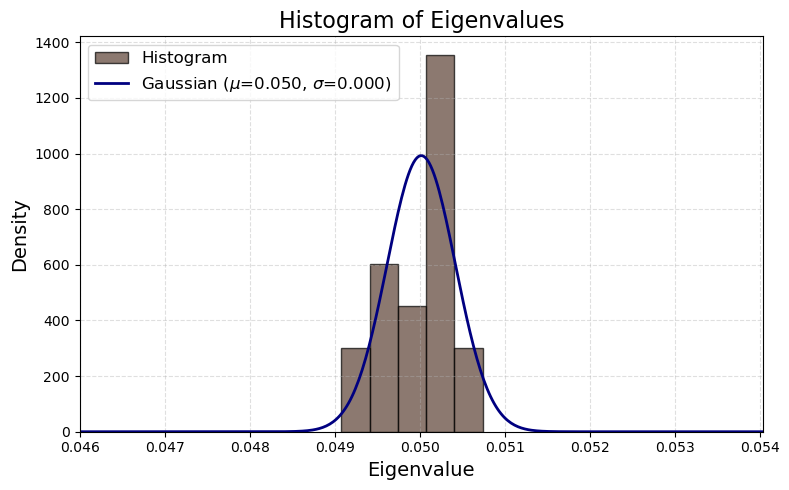

In [16]:
# Plot the histogram of the eigenvalues and overlay a Gaussian fit
import numpy as np
from scipy.stats import norm

eigenvalues = y
mean = np.mean(eigenvalues)
std = np.std(eigenvalues)

plt.figure(figsize=(8, 5))
# Plot histogram
counts, bins, patches = plt.hist(eigenvalues, bins=5, color='#5c4033', alpha=0.7, edgecolor='black', density=True, label='Histogram')

# Overlay Gaussian
# Set x limits far from the mean to emphasize the narrowness
xlim_pad = 10  # how many stds to pad on each side
x_min = mean - xlim_pad * std
x_max = mean + xlim_pad * std
x = np.linspace(x_min, x_max, 400)
pdf = norm.pdf(x, mean, std)
plt.plot(x, pdf, color='navy', linewidth=2, label=f'Gaussian ($\\mu$={mean:.3f}, $\\sigma$={std:.3f})')

plt.xlabel('Eigenvalue', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Histogram of Eigenvalues', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=12)
plt.xlim(x_min, x_max)
plt.tight_layout()
plt.show()

In [49]:
ls = np.array(losses[2300:])

In [50]:
np.mean(ls)

/home/akiva/miniconda3/envs/ml_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/akiva/miniconda3/envs/ml_env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

In [51]:
np.std(ls)

/home/akiva/miniconda3/envs/ml_env/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/akiva/miniconda3/envs/ml_env/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/akiva/miniconda3/envs/ml_env/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

In [11]:
epoch > 2_000_000 * 0.8

False

In [17]:
import sys
sys.path.append('/home/akiva/FCNX-Ensembling/')

from GPKit import *
true_gpr = gpr_dot_product_explicit(X, Y, X, 1.0).cpu().detach()
prediction = model(X).cpu().detach().mean(-1)
tru_y =  Y.cpu().cpu().detach()
prediction.shape

torch.Size([20, 1])

tru_y_np shape: (20, 1)
true_gpr_np shape: (20, 1)
prediction_np_cpu shape: (20, 1)
X_np shape: (20, 20)
MSE similarity between true_gpr_np and prediction_np: 0.003125589338144206
MSE similarity between prediction_np and tru_y_np: -0.010469632879552035
MSE similarity between true_gpr_np and tru_y: -0.007344043541407827


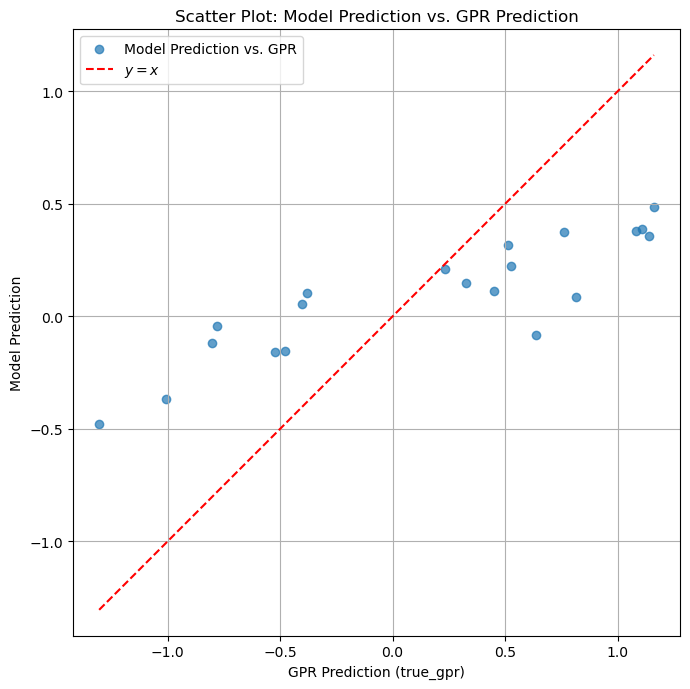

In [18]:


# Move all data to CPU numpy arrays
tru_y_np = tru_y.numpy() if hasattr(tru_y, 'cpu') else tru_y
true_gpr_np = true_gpr.cpu().numpy() if hasattr(true_gpr, 'cpu') else true_gpr
prediction_np = prediction.cpu().numpy() if hasattr(prediction, 'cpu') else prediction
X_np = X.cpu().detach().numpy() if hasattr(X, 'cpu') else X

# Print shapes of all these arrays/tensors
print("tru_y_np shape:", getattr(tru_y_np, "shape", "no shape"))
print("true_gpr_np shape:", getattr(true_gpr_np, "shape", "no shape"))
print("prediction_np_cpu shape:", getattr(prediction_np, "shape", "no shape"))
print("X_np shape:", getattr(X_np, "shape", "no shape"))



def cosine_similarity(a, b):
    """
    Compute the cosine similarity between two numpy arrays.
    """
    a_flat = a.ravel()
    b_flat = b.ravel()
    numerator = np.dot(a_flat, b_flat)
    denominator = np.linalg.norm(a_flat) * np.linalg.norm(b_flat)
    cossim = numerator / denominator if denominator != 0 else np.nan
    return np.arccos(cossim) * 180 / np.pi 

def me(a,b):
    return np.mean((a - b))  / num_samples

# Compute cosine similarity between true_gpr_np and prediction_np

mse_nn_gpr = me(true_gpr_np, prediction_np) 
print("MSE similarity between true_gpr_np and prediction_np:", mse_nn_gpr)

# Compute cosine similarity between true_gpr_np and tru_y
mse_nn_truy = me(prediction_np, tru_y_np) 
print("MSE similarity between prediction_np and tru_y_np:", mse_nn_truy)

# Compute cosine similarity between true_gpr_np and tru_y
mse_gpr_truy = me(true_gpr_np, tru_y_np) 
print("MSE similarity between true_gpr_np and tru_y:", mse_gpr_truy)
import matplotlib.pyplot as plt
import numpy as np

# Ensure prediction is a numpy array for plotting
if hasattr(prediction, "detach"):
    prediction_np = prediction.detach().cpu().numpy()
else:
    prediction_np = np.array(prediction)

# Flatten arrays if needed for scatter plot
gpr_flat = true_gpr.flatten()
pred_flat = prediction_np.flatten()

plt.figure(figsize=(7, 7))
plt.scatter(gpr_flat, pred_flat, alpha=0.7, label='Model Prediction vs. GPR')
min_val = min(gpr_flat.min(), pred_flat.min())
max_val = max(gpr_flat.max(), pred_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='$y=x$')
plt.xlabel('GPR Prediction (true_gpr)')
plt.ylabel('Model Prediction')
plt.title('Scatter Plot: Model Prediction vs. GPR Prediction')
plt.legend()
plt.axis('equal')  # Keep x and y axis with the same scale
plt.grid(True)
plt.tight_layout()
plt.show()


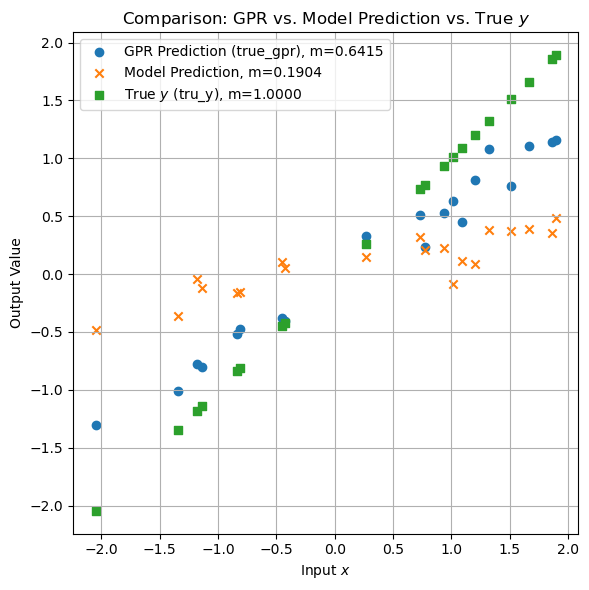

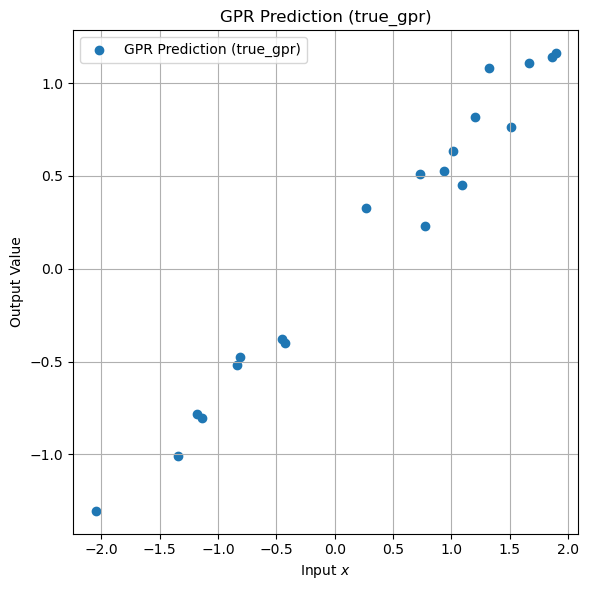

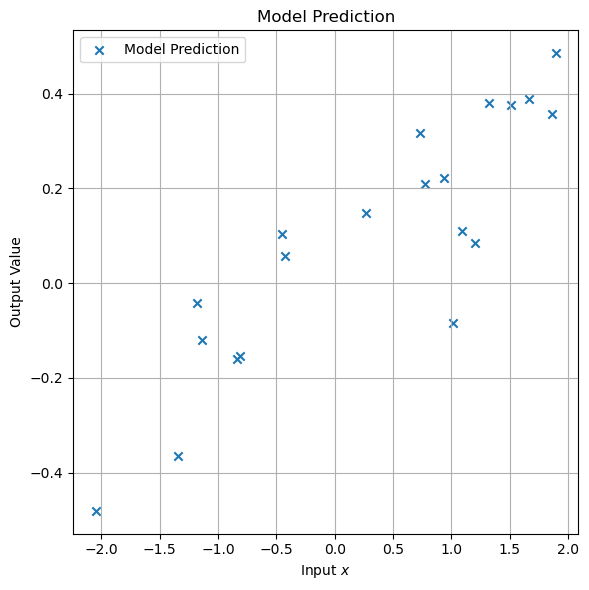

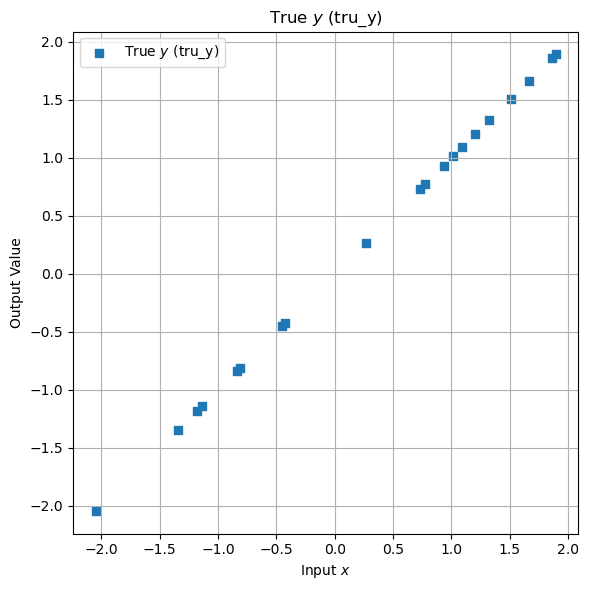

In [19]:
slope = lambda x, y: np.polyfit(x, y, 1)[0].item() if len(x) == len(y) else None
import matplotlib.pyplot as plt
import numpy as np

# Ensure prediction is a numpy array for plotting
if hasattr(prediction, "detach"):
    prediction_np = prediction.detach().cpu().numpy()
else:
    prediction_np = np.array(prediction)

# Use x[:,0] as the x-axis for plotting
if hasattr(X, "detach"):
    x_plot = X.detach().cpu().numpy()
else:
    x_plot = np.array(X)
x_axis = x_plot[:,0] if x_plot.ndim > 1 else x_plot

# Plot comparison of true_gpr, prediction, and tru_y
plt.figure(figsize=(6, 6))
s1 = slope(x_axis, true_gpr)
s2 = slope(x_axis, prediction_np[:, 0] if prediction_np.ndim > 1 else prediction_np)
s3 = slope(x_axis, tru_y[:, 0] if tru_y.ndim > 1 else tru_y)
plt.scatter(x_axis, true_gpr, label=f'GPR Prediction (true_gpr), m={s1:.4f}', marker='o')
plt.scatter(x_axis, prediction_np[:, 0] if prediction_np.ndim > 1 else prediction_np, label=f'Model Prediction, m={s2:.4f}', marker='x')
plt.scatter(x_axis, tru_y[:, 0] if tru_y.ndim > 1 else tru_y, label=f'True $y$ (tru_y), m={s3:.4f}', marker='s')


plt.xlabel('Input $x$')
plt.ylabel('Output Value')
plt.title('Comparison: GPR vs. Model Prediction vs. True $y$')
plt.legend()
plt.grid(True)
plt.tight_layout()
# Plot each curve in a separate figure, one beneath the other

# Plot 1: GPR Prediction (true_gpr)
plt.figure(figsize=(6, 6))
plt.scatter(x_axis, true_gpr, label='GPR Prediction (true_gpr)', marker='o')
plt.xlabel('Input $x$')
plt.ylabel('Output Value')
plt.title('GPR Prediction (true_gpr)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Model Prediction
plt.figure(figsize=(6, 6))
plt.scatter(x_axis, prediction_np[:,0] if prediction_np.ndim > 1 else prediction_np, label='Model Prediction', marker='x')
plt.xlabel('Input $x$')
plt.ylabel('Output Value')
plt.title('Model Prediction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: True y (tru_y)



plt.figure(figsize=(6, 6))
plt.scatter(x_axis, tru_y[:,0] if tru_y.ndim > 1 else tru_y, label='True $y$ (tru_y)', marker='s')
plt.xlabel('Input $x$')
plt.ylabel('Output Value')
plt.title('True $y$ (tru_y)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
getslope = lambda x, y: np.polyfit(x, y, 1)[0].item() if len(x) == len(y) else None

import os
import torch
import re
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm


model_dir = file
epochs = []
slopes = []
cosine_similarities = []
X.requires_grad_(True)

for filename in os.listdir(model_dir):
    if filename.startswith("model_epoch_") and filename.endswith(".pth"):
        filepath = os.path.join(model_dir, filename)
        match = re.search(r"model_epoch_(\d+)\.pth", filename)
        if match:
            epoch = int(match.group(1))
            epochs.append(epoch)
            model.load_state_dict(torch.load(filepath, map_location=device))
            model.eval()
            X_clone = X.clone()
            output = model(X_clone).mean(axis=-1).to('cpu').detach().numpy()
            slope = getslope(true_gpr_np[:,0], output[:,0])
            slopes.append(slope)
            # Compute cosine similarity of model output against true_gpr_np
            model_output_flat = output.flatten()
            true_gpr_flat = true_gpr_np[:,0].flatten()
            cosine_similarity = np.dot(model_output_flat, true_gpr_flat) / (norm(model_output_flat) * norm(true_gpr_flat))
            cosine_similarities.append(cosine_similarity)




In [22]:
sorted_indices = np.argsort(epochs)
epochs_sorted = np.array(epochs)[sorted_indices]
slopes_sorted = np.array(slopes)[sorted_indices]
cos_sorted = np.array(cosine_similarities)[sorted_indices]

In [23]:
true_slope = getslope(X.to('cpu').detach().numpy()[:,0], Y.to('cpu').detach().numpy())
m_gpr = getslope(true_gpr_np[:,0], true_gpr_np[:,0])

Text(0.02, 0.98, 'Recorded on 20250716_172110')

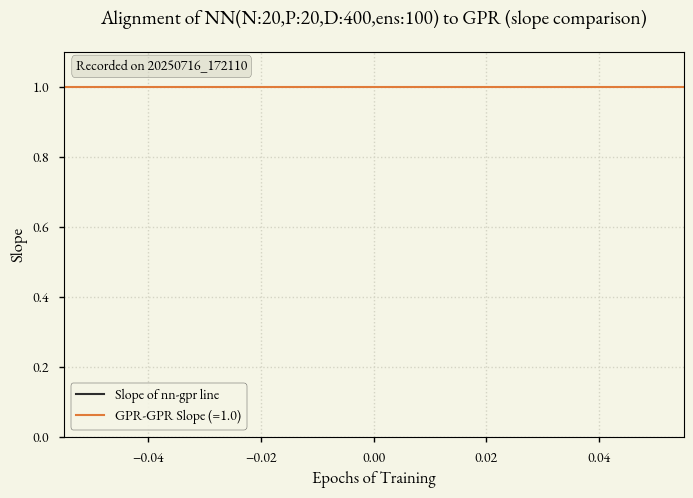

In [24]:
# Ensure Matplotlib recognizes the custom font
from matplotlib import font_manager
font_path = '/home/akiva/fonts/EBGaramond.ttf'
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'EB Garamond'

# Custom Victorian style
plt.style.use('seaborn-v0_8-notebook')
plt.rcParams.update({
    'font.size': 12,
    'axes.facecolor': '#f5f5e6',  # Parchment background
    'figure.facecolor': '#f5f5e6',
    'grid.color': '#d4d4c4',
    'grid.linestyle': ':',
    'lines.linewidth': 1.5,
})

plt.figure(figsize=(8, 5))
plt.plot(epochs_sorted, slopes_sorted, marker='x', linestyle='-', color='#2e2e2e', label='Slope of nn-gpr line')
# plt.axhline(y=true_slope, color='#355e3b', linestyle='--', label=f'True Slope = {true_slope:.2f}')
plt.axhline(y=m_gpr, color='#e07b39', linestyle='-', label='GPR-GPR Slope (=1.0)')
plt.title('Alignment of NN(N:20,P:20,D:400,ens:100) to GPR (slope comparison)', fontsize=14, pad=20)
plt.xlabel('Epochs of Training', fontsize=12)
plt.ylabel('Slope', fontsize=12)
plt.ylim(0, 1.1)
plt.grid(True)
from datetime  import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
plt.legend(frameon=True, framealpha=0.9, edgecolor='#2e2e2e')
plt.text(0.02, 0.98, f'Recorded on {timestamp}', transform=plt.gca().transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='#d4d4c4', alpha=0.5))
# plt.savefig(os.path.join(save_dir, f"slope_epoch_{epoch+1}.png"), dpi=300, bbox_inches='tight')
# writer.add_figure('Slope/Over_Epochs', plt.gcf(), global_step=epoch)
# plt.close()

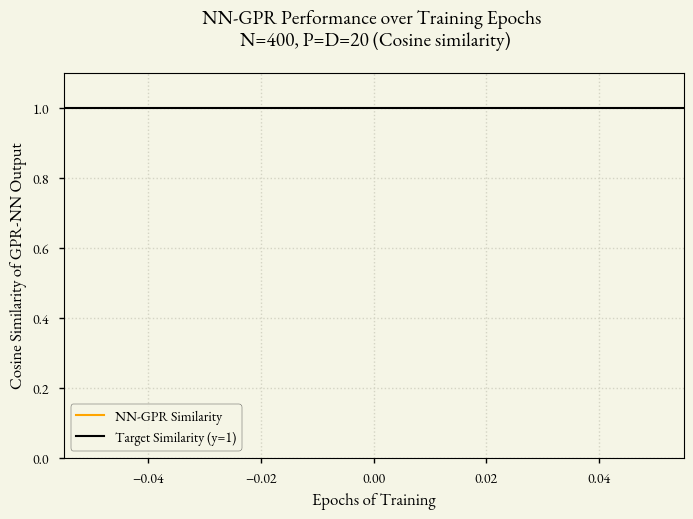

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(epochs_sorted, cos_sorted, linestyle='-', color='orange', label='NN-GPR Similarity')
plt.axhline(y=1.0, color='black', linestyle='-', linewidth=1.5, label='Target Similarity (y=1)')
plt.title('NN-GPR Performance over Training Epochs \n N=400, P=D=20 (Cosine similarity)', fontsize=14, pad=20)
plt.xlabel('Epochs of Training', fontsize=12)
plt.ylabel('Cosine Similarity of GPR-NN Output', fontsize=12)
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend(frameon=True, framealpha=0.9, edgecolor='#2e2e2e')
plt.show()

In [23]:
1

1